## Investigating Site Characteristics Relationship with Factor Analysis

The purpose of this notebook is to demonstrate the process of performing an *Exploratory Factor Analysis (EFA)* on the Ames Housing dataset. The demonstration herein is encoded using *R*. The dataset can be found and downloaded from *Kaggle* (https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data).

In [ ]:
# required libraries
library(lavaan)
library(doParallel)
library(itertools)
library(missForest)
library(foreach)
library(mlr)
library(psych)
library(GPArotation)
library(nFactors)
library(qgraph)
library(corrplot)
library(tidyr)
library(dplyr)
library(lattice)
library(gdata)
library(readr)
library(corrplot)
library(MVN)
library(ggplot2)
library(ggm)

### 1. Introduction  
The Ames Housing dataset  contains 80 measures of house features on 2,919 homes. These measures include home quality and condition scores such as, `exterior quality`, `kitchen quality`, `garage condition` and `overall condition`. They also included numerical measure such as, `number of half-baths`, `number of bedrooms`, `lot area` in metres, as well as descriptive measure of homes such as `house type`, `utility type`, and `lot configuration`.

To use this interactive notebook, download the dataset as a *CSV* file and input the file path and name of the downloaded *CSV* file in quotations in the `data_file_path` variable's definition below.

In [2]:
data_file_path = "file_path/filename.csv"
data <- read.csv(data_file_path, stringsAsFactors = FALSE)

### 2. Data Cleaning

In order to perform the *EFA*, the data has to be cleaned and transformed into a suitable format for analysis. Firstly, the columns holding nominal data features are removed because, unlike ordinal and quantitative data, nominal data do not have a natural numerical order. This means measures of central tendency like the *observation mean* cannot be computed for nominal data features. As the methods described here require the *EFA* to use derivatives of these measures in the *factor solution*, we remove the 47 columns holding nominal data features. 

Secondly, we transform the ordinal data features into their numerical representations and transform their missing values. The dataset contains 13 of these ordinal data features which all describe the condition or quality of a home feature on one of two graded scales. The first is a scale with a descriptive grade: ` Excellent`, `Good`, `Typical/Average`, `Fair` and `Poor`. The data features on this scale are transformed onto a 1:5 scale below. The second scale is 1:10. The two features on this scale are transformed onto the 1:5 scale to match the other ordinal features. Then the the null values within all ordinal features are transformed into zero values, as the NA values here indicate that the feature being measured is not present for the home. 

Next, the quantitative numerical data is treated for outliers, where any observations that lie three standard deviations above the feature mean are removed and replaced with null values. Finally, any data features or rows missing more than 25% of the observations are removed. This results in 5 of the features and 70 rows to be dropped. The remaining 1489 values are estimated using *multiple imputation*. Multiple imputation includes a variety of statistical and machine learning techniques used to predict the missing values, given the other feature observations. Here we use a *Random Forest model* to predict the missing values. A *Random Forest model* is an ensemble machine learning technique that utilises the *mean prediction* given by a group of trained *Decision Tree models*.

Warning message:
“Removed 35028 rows containing missing values (geom_raster).”

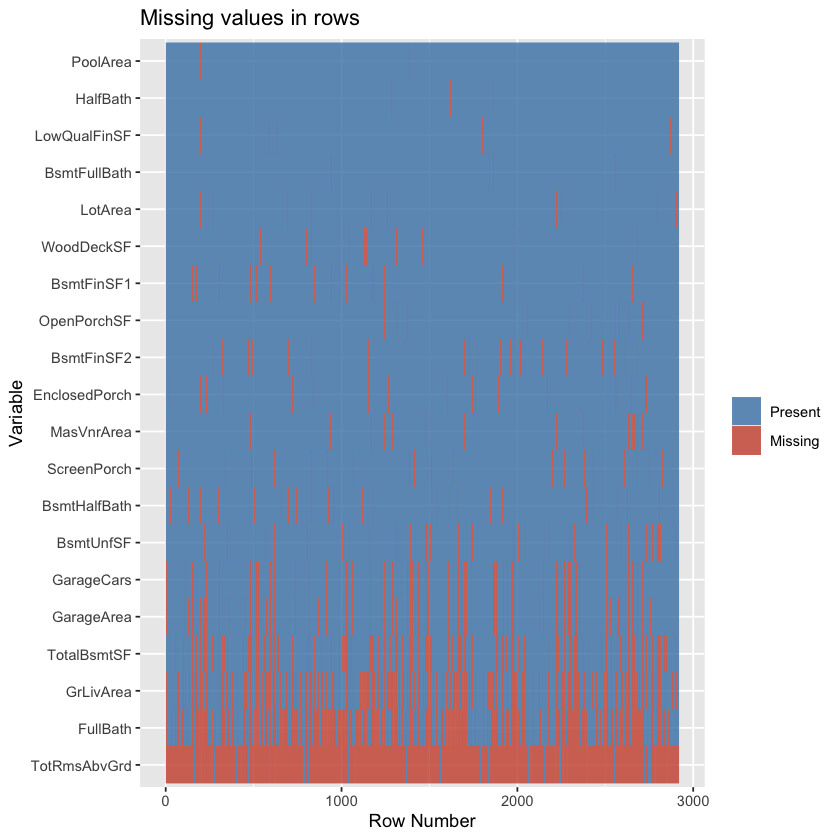

In [3]:
# removes all features that are nominal or descriptive leaving only numeric and ordinal data features
col_names = c("LotArea", "OverallQual", "OverallCond", "MasVnrArea", "ExterQual", "ExterCond", "BsmtQual", "BsmtCond",
                 "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF","HeatingQC", "1stFlrSF",
                 "2ndFlrSF", "LowQualFinSF", "GrLivArea", "BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath", "Bedroom", 
                 "Kitchen", "KitchenQual", "TotRmsAbvGrd", "Fireplaces", "FireplaceQu", "GarageCars", "GarageArea", "GarageQual","GarageCond", 
                  "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea", "PoolQC")
names.use <- names(data)[(names(data) %in% col_names)]
data.subset <- data[, names.use]

# isolates ordinal cols from numeric so they can undergo their separate data cleaning 
known_na = c("ExterCond","OverallQual", "OverallCond", "ExterQual", "BsmtQual", "BsmtCond", "HeatingQC", "KitchenQual", "Fireplaces",
  "FireplaceQu", "GarageQual", "GarageCond", "PoolQC")
names.use <- names(data.subset)[!(names(data.subset) %in% known_na)]
data.subset4 <- data.subset[, names.use]

# isolates the known rank features so we can change the grade to a numeric representation and transform THESE NAs to 
# zero values (this NA treatment is specific to these features because a NA here means the feature isn't present )
known_na = c("ExterCond","OverallQual", "OverallCond", "ExterQual", "BsmtQual", "BsmtCond", "HeatingQC", "KitchenQual",
  "FireplaceQu", "GarageQual", "GarageCond", "PoolQC")
names.use <- names(data.subset)[(names(data.subset) %in% known_na)]
data.subset2 <- data.subset[, names.use]
data.subset2[is.na(data.subset2)] <- 0
data.subset2[data.subset2== "Ex"] <- 5 
data.subset2[data.subset2== "Gd"] <- 4
data.subset2[data.subset2== "TA"] <- 3
data.subset2[data.subset2== "Fa"] <- 2
data.subset2[data.subset2== "Po"] <- 1
col_names = known_na[-c(2,3)]
data.subset2[,col_names] <- data.frame(apply(data.subset2[col_names], 2, as.numeric))


# creates subset 3 from subset2 to isolate two ordinal features with 1:10 grade scale 
large_levels = c("OverallQual", "OverallCond")
names.use <- names(data.subset2)[(names(data.subset2) %in% large_levels)]
data.subset3 <- data.subset2[, names.use]

# transforms from 1:10 scale to 1:5 scale
data.subset3[data.subset3== 2 | data.subset3== 1 ] <- 1
data.subset3[data.subset3== 3 | data.subset3== 4 ] <- 2
data.subset3[data.subset3== 5 | data.subset3== 6 ] <- 3
data.subset3[data.subset3== 7 | data.subset3== 8 ] <- 4
data.subset3[data.subset3== 9 | data.subset3== 10 ] <- 5

#removes rank cols from data subset 2 that now in subset 3 
data.subset2 = data.subset2[,-c(1,2)]

findOutlier <- function(data, cutoff=3) {
    ## Calculate the sd
    sds <- apply(data, 2, sd, na.rm=TRUE)
    ## Identify the cells with value greater than cutoff * sd (column wise)
    result <- mapply(function(d, s) { 
        which(d > cutoff * s)
        },
        data, sds
    )
    result
}
# calls outlier function on the numeric data subset
outliers <- findOutlier(data.subset4)

# removes all the observation that are marked as outliers by the outlier function
removeOutlier <- function(data, outliers) {
    result <- mapply(function(d, o) {
        res <- d
        res[o] <- NA
        return(res)
    }, data, outliers)
    return(as.data.frame(result))
}

# calls the remove outlier function on numeric data subset
data.subset4 <- removeOutlier(data.subset4, outliers)

#combines all subsets back together
ndata = cbind(data.subset2, data.subset3, data.subset4)

# visualise NAs produced by outlier detection
missing.values <- ndata %>%
  gather(key = "key", value = "val") %>%
  mutate(isna = is.na(val)) %>%
  group_by(key) %>%
  mutate(total = n()) %>%
  group_by(key, total, isna) %>%
  summarise(num.isna = n()) %>%
  mutate(pct = num.isna / total * 100)


levels <-
  (missing.values  %>% filter(isna == T) %>% arrange(desc(pct)))$key

percentage.plot <- missing.values %>%
  ggplot() +
  geom_bar(aes(x = reorder(key, desc(pct)), 
               y = pct, fill=isna), 
           stat = 'identity', alpha=0.8) +
  scale_x_discrete(limits = levels) +
  scale_fill_manual(name = "", 
                    values = c('steelblue', 'tomato3'), labels = c("Present", "Missing")) +
  coord_flip() +
  labs(title = "Percentage of missing values", x =
         'Data Feature', y = "% of missing values")

row.plot <- ndata %>%
  mutate(id = row_number()) %>%
  gather(-id, key = "key", value = "val") %>%
  mutate(isna = is.na(val)) %>%
  ggplot(aes(key, id, fill = isna)) +
  geom_raster(alpha=0.8) +
  scale_fill_manual(name = "",
                    values = c('steelblue', 'tomato3'),
                    labels = c("Present", "Missing")) +
  scale_x_discrete(limits = levels) +
  labs(x = "Data Feature",
       y = "Row Number", title = "Missing values in rows") +
  coord_flip()

row.plot

#drops the rows and features that have ~25% or more missing
ndata <- ndata[-which(rowSums(is.na(ndata)) >= 8), ]
ndata <- ndata[,-which(colSums(is.na(ndata)) >= 365 ) ]

The plot above shows the missing data from the dataset after the nominal features have been removed. The plotted data features are arranged in descending order by total number of missing observations. We can see from the plot that the first 5 features (from the bottom of the y-axis) have a large percentage of missing data. We can also see that the rest of the features don't have an obvious pattern of missing-ness. For example, we do not see that there are more missing values in certain rows or features which would indicate a data collection issue. As the spread of missing values after the first five features seems to be random, we can use multiple imputation to estimate these values. 

In [4]:
# creates a complete dataset to compare imputed dataset to 
comp <- ndata[-which(rowSums(is.na(ndata)) > 0),]

#imputs missing values
set.seed(397)

# creates cluster for parallel compute capacity
cl <- makeCluster(2)
registerDoParallel(cl)

# performs random forest multiple imputation
im.out.2 <- missForest(xmis = ndata, maxiter = 10, ntree = 500,
                       variablewise = FALSE,
                       decreasing = FALSE, verbose = FALSE,
                       replace = TRUE,
                       classwt = NULL, cutoff = NULL, strata = NULL,
                       sampsize = NULL, nodesize = NULL, maxnodes = NULL,
                       parallelize = "variables")

# creates dataframe with missing values replaced with estimates from imputation
cdata <- cbind(im.out.2$ximp)

# stops cluster (IMPORTANT!!!)
stopCluster(cl)



  missForest iteration 1 in progress...done!
  missForest iteration 2 in progress...done!
  missForest iteration 3 in progress...done!
  missForest iteration 4 in progress...done!
  missForest iteration 5 in progress...done!


### 3. Exploratory Analysis

#### 3.1 Assessing the Quality of Information within the  Features

Once the data is free of missing values and outliers, we assess the distribution of observations in each data feature. First, we remove the features in the data that have very low variance. Here, this means a feature that has the same value for more than 60% of the observations. Features with very low variance don't contribute to the total variance in the data that we are trying to explain through *EFA*. 

For example, in the density plots below we can see that the `LowQualFiSF` feature is zero for over 2,000 of the 2,849 total observations. We found 9 similar cases below of these features using density plots of the observed distribution of each feature below.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


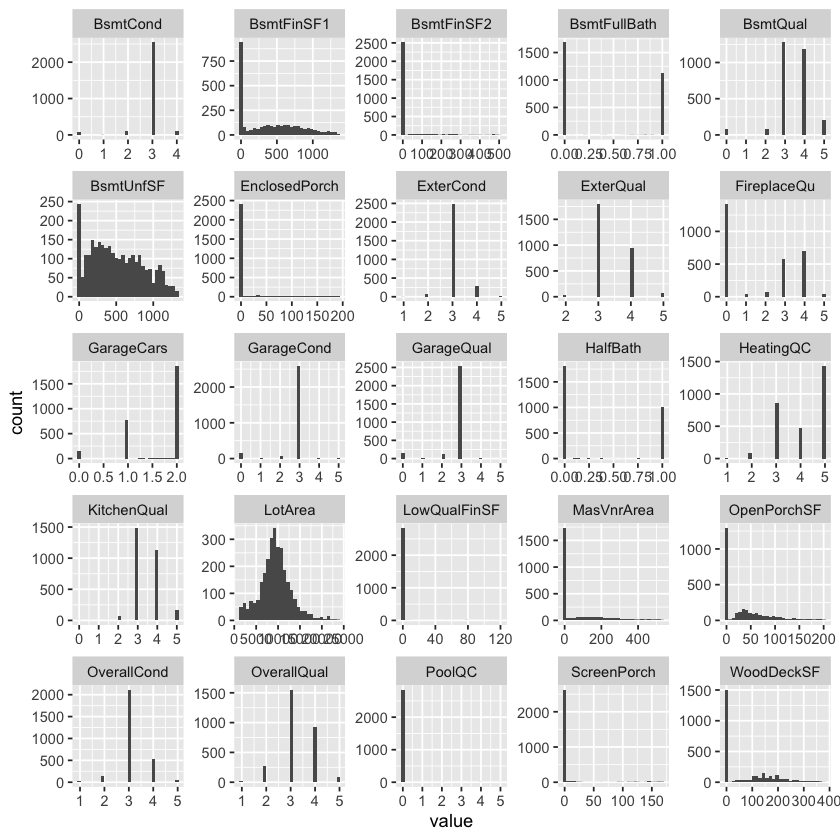

In [5]:
# removes any features with zero variance
cdata <- cdata[ - as.numeric(which(apply(cdata, 2, var) == 0))]

# plots the rest of the features as density features 
cdata %>%
  gather() %>%                             
  ggplot(aes(value)) +                     
    facet_wrap(~ key, scales = "free") +   
    geom_histogram()      

#### 3.2 Correlation Between Features

Next, we visualise the correlation between all the features as shown in the figure below. We can see that there is correlation between some of the features which we hope is due to their shared association to a latent factor within the data. We don't want perfect correlation as it suggests that instead, the common variance is due to the fact that one is completely explained by the other. According to the *correlation plot* below, there is no cause for concern. 

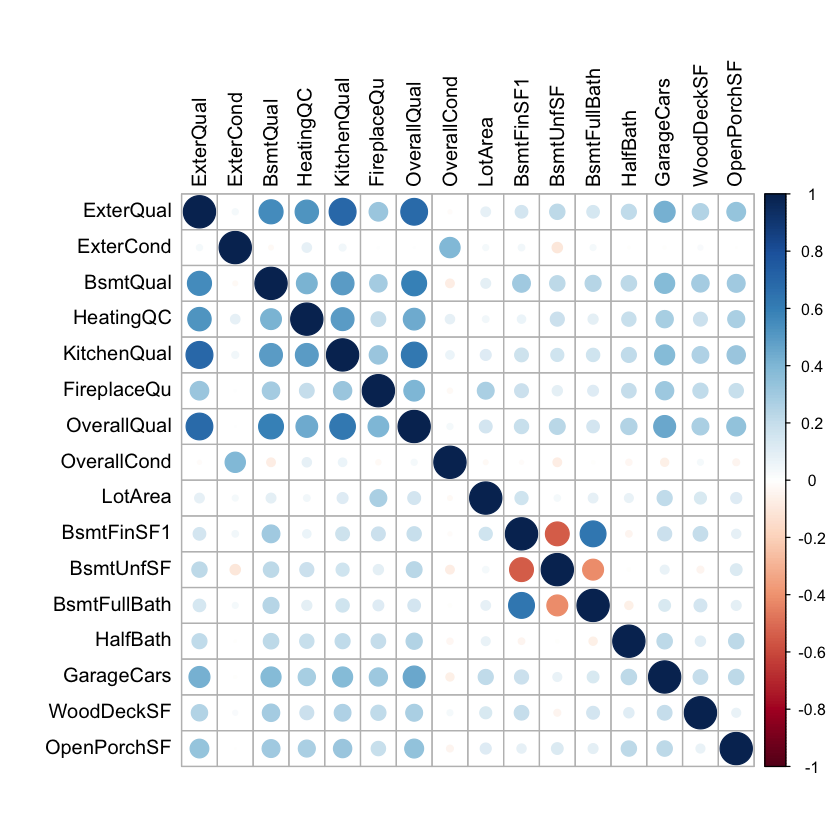

In [6]:
# removes features with very little variance 
cdata = cdata[,!names(cdata) %in% c("BsmtCond","GarageCond", "EnclosedPorch", "ScreenPorch", 
                                    "BsmtFinSF2", "GarageQual", "LowQualFinSF", "PoolQC", "ScreenPorch", "MasVnrArea")]
# shows correlation matrix plot
corrplot(cor(cdata), tl.col = "black")

### 4.  Factor Analysis

#### 4.1 Choose the Number of Factors to Extract

*Factor analysis* will produce the same number of factors as there are features in the original data. One of the reasons for running a *factor analysis* is to reduce the data into a smaller number of interpretable factors that explain the maximum amount variability in the data. The first step is to determine what number of factors is most optimal. We inspected the eigenvalues from an initial *factor analysis* without any rotation, using a *scree plot* of a *parallel analysis*. This was performed to determine the number of factors to retain in the *EFA*. 

The *parallel analysis* generates a random dataset with the same dimensions as the data under analysis, and compares the *eigenvalues* of the research data to the respective *eigenvalues* of the random dataset. The factors retained from the real data are the components which have a higher *eigenvalues* than the *parallel components* of the randomly generated data. The results from the analysis were plotted in a *scree plot* for comparison. The *parallel analysis* and *scree plot* suggested that a solution of five factors describe the majority of the *covariance* between the original features, and thus it can be concluded that the data can be well described using only the first five factors. See the *Factor Analysis* section of the report for more details on *eigenvalues* and *scree plots*.

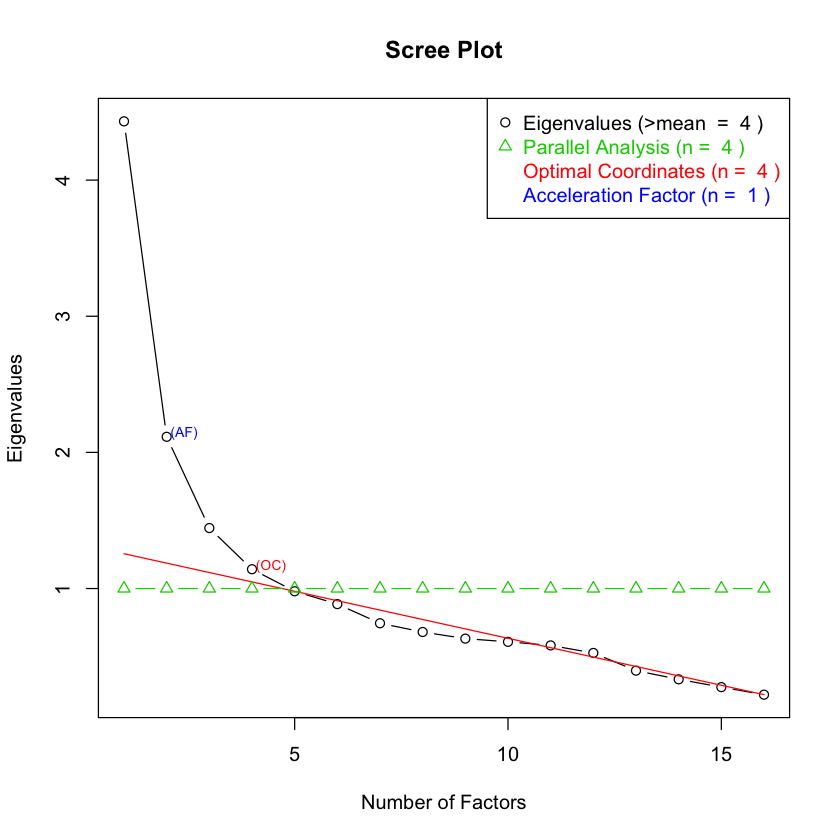

In [7]:
# gets eigenvalues
ev <- eigen(cor(cdata)) 

# performs parallel analysis
nS <- nScree(x = ev$values) 

# plots scree plot
plotnScree(nS, legend = TRUE,
            ylab   = "Eigenvalues",
            xlab   = "Number of Factors",
            main   = "Scree Plot"
            )

#### 4.2 Performing and Tuning the *Factor Analysis*

Once the factors are extracted the new dimensions are rotated within the data space in away that organises the observations along the new dimensions that best suits the research goal. More specifically, the rotation chosen dictates whether the factors produced can be uncorrelated (*oblique rotation*) or correlated with each other (*orthogonal*). An *orthogonal rotation* was chosen using the *Varimax* argument within the `fa()` function as the *correlation* plot above did not show an overwhelming amount of correlation between many features. 

The relationship of each feature to a given factor can be assessed by the feature's *loading* value. The higher the loading, the stronger the relationship between the feature and factor. We would associate a feature to a particular factor if the loading is at least ±0.3. Any value below this indicates a weak feature relationship with the factor. 

Below the *EFA* is defined using four factors and an *oblique rotation*. The *loading* results below show the value of a loading if the loading is above 0.3. If there are no loading values for a particular feature, this means that the feature didn't load on any of the factors above 0.3. We also look for features that load high (above 0.3) on more than one factor which are called *cross-loading items*. Retaining several of these high cross-loading items impedes the ability to find and interpret the latent structures, since the features used to describe them are not unique to the factors.

In [8]:
# Performs factor analysis with a varimax (orthogonal rotation)
efa_var = fa(cdata, rotate = "Varimax", nfactors = 4)

# prints the loadings matrix of all the loadings from the EFA with value above 0.3
print(efa_var$loadings,cutoff = 0.3)


Loadings:
             MR1    MR2    MR3    MR4   
ExterQual     0.842                     
ExterCond                   0.539       
BsmtQual      0.693                     
HeatingQC     0.623                     
KitchenQual   0.774                     
FireplaceQu   0.376                0.465
OverallQual   0.796                     
OverallCond                 0.724       
LotArea                            0.476
BsmtFinSF1           0.912              
BsmtUnfSF     0.307 -0.643              
BsmtFullBath         0.699              
HalfBath                                
GarageCars    0.482                0.310
WoodDeckSF                              
OpenPorchSF   0.412                     

                 MR1   MR2   MR3   MR4
SS loadings    3.672 1.836 0.875 0.674
Proportion Var 0.230 0.115 0.055 0.042
Cumulative Var 0.230 0.344 0.399 0.441


The results from the *EFA* showed that the factor structure showed that `FireplaceQu`, `GarageCars` items cross-loaded on two factors and that the following features didn't load above 0.3 on any factor:

- `HalfBath`
- `WoodDeckSF`

We don't want features which are either not factored or not unique to factors as they affect the interpretability of the results, but we also want to be careful about removing more of the features than we already have. We also might find that removing a particular feature changes the results. To balance these issues we re-run analysis to see if the *EFA* improves by some criteria. However, a consideration of which items to remove and in what order, needs to be made. In order to achieve the best results, the complex items were identified, and an *EFA* was run with each of the items removed in every possible combination. For each of these tests, the *Root Mean Square Error of Approximation (RMSEA)* was stored and used as the criteria of best fit. The combination of complex items, that once removed returned the lowest *RMSEA*, were chosen for exclusion.

In [54]:
# features that have no loadings above 0.3 
cols = c("HalfBath", "WoodDeckSF")

# gets the column index for these features
col_nums = c()
i = 1
for(col in cols){
  col_num = which( colnames(cdata)== col)
  col_nums[[i]] <- col_num
  i <- i + 1
}

# creates a list of all the possible subsets
subs <- powerset(col_nums) 

# does a factor analysis with each possible combination of the complex items removed and stores each resulting RMSE in a vector
rmses = c()
for (i in 1:length(subs)) {
  delcol <- subs[[i]]
  splits <- fa(cdata[,-delcol], rotate = "Varimax", nfactors = 4)
  rmses[i] <- as.numeric(unlist(splits$RMSEA[[1]]))
}

# gets the column indicies that when dropped returned 
drop_cols = subs[which.min(unlist(rmses))]

# creates reduced dataset
c_reduced = cdata[, -c(unlist(drop_cols))]

# names features nicer for plot 
new_col_names = c("Exterior Qual.", "Exterior Cond.", "Basement Qual.", "Heating Qual.", "Kitchen Qual", "Fireplace Qual.",
                  "Overall Qual.", "Overall Cond.", "Lot Area", "Basement Finished Area", "Basement Unfinished Area",
                  "Basement Full Baths", "Garage No. Cars", "Open Porch Area")

# assigns new names to reduced data
names(c_reduced) = new_col_names



# defines FA without items 
efa_splits <- fa(c_reduced, rotate = "Varimax", nfactors = 4)

### 5. Assessing & Interpreting *Factor Analysis* Solution

In *EFA*, several statistical tests are used to determine how well the model fits to the data. Note that a good fit between the *factor model* and the data does not mean that it is the best possible model. A “good model fit” only indicates that the *factor model* had been fitted well to the data which is available to it. From the model output, the following measures of accuracy were used to evaluate the *EFA solution*:

- **The Root Mean Square of the Residuals (RMSR):** is an index of the average of residuals (i.e. difference) between the values of the observed and model covariance matrices. *RMSR* it can be interpreted as the indicator of "good model  fit" when it produces a value lower than 0.05. 
- **The root mean square error of approximation (RMSEA):** analyses the discrepancy between the model and sample covariance matrix adjusted for the model sample size and number of features. The *RMSEA* value ranges 0 to 1, in which smaller values indicate better model fit. A value of .06 or less indicates "good model fit".
- **Tucker Lewis Index (TLI):** *TLI* is a Relative fit index which calculates a chi-square test for both the factor model and a null model in which observed features are uncorrelated (i.e. no factors can be extracted). The fit index is computed by using ratios of the model chi-square and the null model chi-square. A value above 0.9 indicates "good model fit". 

The *RMSR* value of 0.02 is acceptable as this value should be closer to zero for lower error *factor solutions*. The example's *factor solution* had a *RMSEA* value of 0.06. Though our example *RMSEA* value is not far from the acceptable range, it suggests that the factor solution can be improved on. Finally, the *TLI* value is 0.92 which suggests that the *factor solution* fits the data very well.

In [55]:
# prints the loadings matrix of all the loadings above 0.3
print(efa_splits$loadings,cutoff = 0.3)

# returns the varriance measures for each factor
print(efa_splits$Vaccounted)

#returns model output with various metrics
print(efa_splits)


Loadings:
                         MR1    MR2    MR3    MR4   
Exterior Qual.            0.844                     
Exterior Cond.                          0.553       
Basement Qual.            0.688                     
Heating Qual.             0.620                     
Kitchen Qual              0.775                     
Fireplace Qual.           0.382                0.421
Overall Qual.             0.800                     
Overall Cond.                           0.705       
Lot Area                                       0.541
Basement Finished Area           0.904              
Basement Unfinished Area  0.313 -0.668              
Basement Full Baths              0.689              
Garage No. Cars           0.485                     
Open Porch Area           0.412                     

                 MR1   MR2   MR3   MR4
SS loadings    3.519 1.802 0.863 0.623
Proportion Var 0.251 0.129 0.062 0.045
Cumulative Var 0.251 0.380 0.442 0.486
                            MR1      

In the *factor diagram* below, we can see that the features that have the highest *loadings* on "Factor 1" are all "quality" measures and thus an appropriate name for the factor may be "Quality Scores Factor". The same logic can be applied to the "Factor 2" and "Factor 3" which we could name "Basement Scores Factor" and "Condition Scores Factor", respectively. We can conclude that the similar observation patterns in the higher *loading* component features are likely due to their shared association to these latent factors. We can also see possible sources of error that were indicated by the slightly high *RMSEA* value in the above model output.

There are two features in "Factor 1" that seem to be out of place: "Open Porch Area" which describes the size of the home's porch, and "Garage No. Cars" which measures the number of cars the home's garage can hold. This odd placement in "Factor 1" may indicate that the relationship between these features and the factor. The *loadings* for these features are lower than the "quality" features which suggest that the relationship between these features and the factor is not strong. Similarly, in factor four the associated features do not seem to have a common concept for which we could name the factor. The *loadings* for the features in factor four are also quite low. These issues suggest that the low *loading* features that are likely associated to latent factors that have not been extracted and that their association to the factors in the solution is due not to a direct relationship between the factor and the features, but to the factor's correlation with the un-extracted factor. It is likely that if the data for features that had to be removed from the analysis were collected in a more robust manner, and therefore able to be considered for the model, then the analysis might have been able to capture the patterns required to extract these factors.

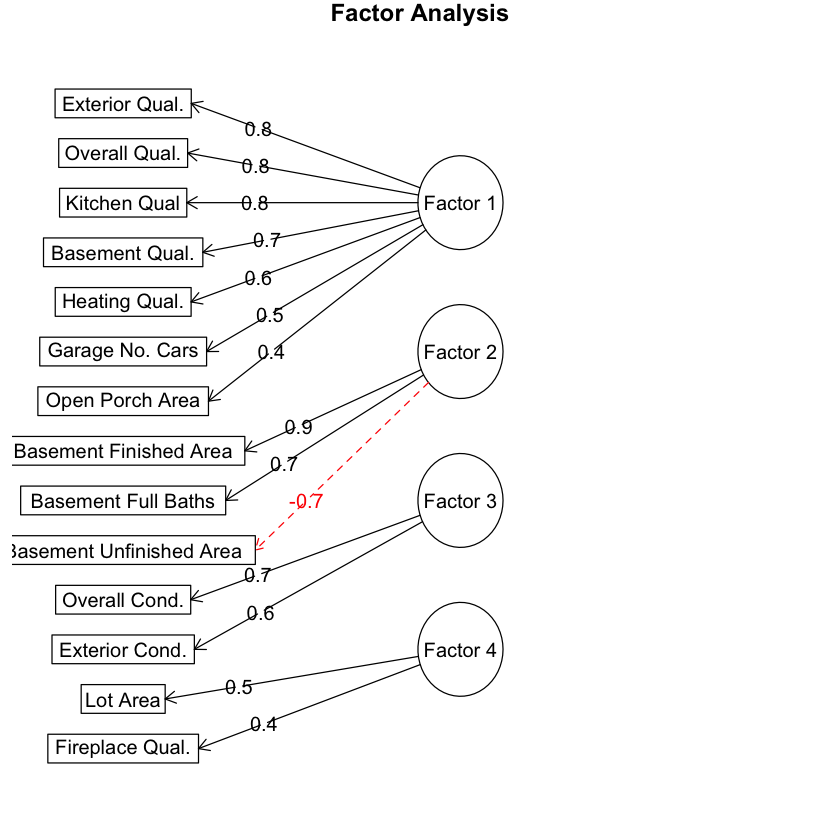

In [56]:
# names the factors for visual
colnames(efa_splits$loadings) <- c("Factor 1", "Factor 2", "Factor 3", "Factor 4")

# creates a factor diagram that shows contents of each factor
fa.diagram(efa_splits) 